In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import hist, show
from matplotlib.ticker import StrMethodFormatter
import datetime
import time
import scipy.stats as ss
import random
from random import randint

## Distribuciones de llegada a las estaciones (retiro de bicis)

In [2]:
retiros = pd.read_csv('Estaciones-Retiros.csv', header= 0)
retiros = retiros.drop('index', axis=1)

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Separamos horarios
tramo5_12 = retiros[(retiros['Retiro_horas'] <= 12)]

tramo12_17 = retiros[(retiros['Retiro_horas'] > 12) & 
                    (retiros['Retiro_horas'] <= 17)]


tramo17_24 = retiros[(retiros['Retiro_horas'] > 17)]

#Contamos retiros por estaciones (en total, i.e. en el año y medio)
u1 = tramo5_12.groupby('Ciclo_Estacion_Retiro')['Ciclo_Estacion_Retiro'].count()
u2 = tramo12_17.groupby('Ciclo_Estacion_Retiro')['Ciclo_Estacion_Retiro'].count()
u3 = tramo17_24.groupby('Ciclo_Estacion_Retiro')['Ciclo_Estacion_Retiro'].count()

#Dividimos entre el número de dias para obtener tasas por dias
#ie promedio de retiros por día
tasas1 = u1 *1/638
tasas2 = u2 *1/638
tasas3 = u3 *1/638

In [4]:
media1 = []
##Lista de estaciones

lista = [196,198,199,200,201,202,203,205,206,207,208,
         209,210,211,212,213,214,215,216,217,218,219,
         220,221,223,224,225,226,228,229,230,231,233,
         235,236,239,240,451,460]


for i in lista: 
    elegido = tasas1[i]
    media1.append(elegido)
    
#media1 #Lista de parametros lambda i . por estaciones (de la 196 a la 460)

media2 = []

for i in lista: 
    elegido = tasas2[i]
    media2.append(elegido)
    
#media2 #Lista de parametros lambda i . por estaciones (de la 196 a la 460)

media3 = []

for i in lista: 
    elegido = tasas3[i]
    media3.append(elegido)
    
#media3 #Lista de parametros lambda i . por estaciones (de la 196 a la 460)

Ahora trabajamos con las estaciones ajenas a Polanco

In [5]:
estaciones_ex = pd.read_csv('EstacionesExternas.csv', header = 0)
#estaciones_ex

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
tramo5_12ex = estaciones_ex[(estaciones_ex['Retiro_horas'] <= 12)]

tramo12_17ex = estaciones_ex[(estaciones_ex['Retiro_horas'] > 12) & 
                    (estaciones_ex['Retiro_horas'] <= 17)]

tramo17_24ex = estaciones_ex[(estaciones_ex['Retiro_horas'] > 17)]

u1ex = tramo5_12ex.groupby('Ciclo_Estacion_Retiro')['Ciclo_Estacion_Retiro'].count()
u2ex = tramo12_17ex.groupby('Ciclo_Estacion_Retiro')['Ciclo_Estacion_Retiro'].count()
u3ex = tramo17_24ex.groupby('Ciclo_Estacion_Retiro')['Ciclo_Estacion_Retiro'].count()

#Obtenemos las tasas de retiro por día:
tasas1ex = u1ex *1/638
tasas2ex = u2ex *1/638
tasas3ex = u3ex *1/638

In [7]:
#Como consideramos a las externas como un solo nodo, sumamos las tasas
#para obtener la tasa total
media1ex = tasas1ex.sum()
media2ex = tasas2ex.sum()
media3ex = tasas3ex.sum()

Lista de tasas de retiro por día de TODAS las estaciones

In [8]:
#Agregamos a la lista de medias internas las externas

media1.append(media1ex)
media2.append(media2ex)
media3.append(media3ex)

## Tiempos de servicio entre estaciones

In [9]:
estaciones = pd.read_csv('Cicloestaciones.csv', header= 0)

In [10]:
### Después de mucho tiempo tratando de entender porqué las gammas 
##no se ajustaban a los datos, caí en la cuenta de que usaba la prueba equivocada KS (pues los parámetros son estimados) y tratando de usar la jicuadrada me di cuenta de que también es erróneo usarla, ya que las ei son pequeñísimas.

#Se eliminan renglones cuya columna TS_Sec sea cero (pues se usará EMV)
estaciones = estaciones[(estaciones != 0).all(1)]

#### Estimar parámetros SIN pruebas de hipótesis.
La siguiente matriz A(i,j) nos da los parámetros de distribuciones gamma asociadas al tiempo de la estación de retiro i (renglón) a la estación arribo j (columna).

In [11]:
##Lista de estaciones

lista = [196,198,199,200,201,202,203,205,206,207,208,
         209,210,211,212,213,214,215,216,217,218,219,
         220,221,223,224,225,226,228,229,230,231,233,
         235,236,239,240,451,460]

l = len(lista)
forma = np.zeros((l,l))
escala = np.zeros((l,l))

for i in range (0,l):
    arribo = estaciones[
        (estaciones['Ciclo_Estacion_Retiro']== lista[i])  
        ]
    for j in range (0,l):
        #Seleccionamos sólo una estación destino
        retiro = arribo[
            (arribo['Ciclo_Estacion_Arribo']== lista[j])  
            ]
        shape, loc, scale = ss.gamma.fit(retiro['TS_Sec'], floc=0)
        forma[i][j] = shape
        escala[i][j] = scale
print("Matriz de parámetros de forma")
#print(forma)
print("Matriz de parámetros de escala")
#print(escala)
        

Matriz de parámetros de forma
Matriz de parámetros de escala


## Probabilidades de transición de una estación a otra

In [12]:
Datos_Transicion = pd.read_csv('Datos_Transicion.csv', header = 0)
#Datos_Transicion

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
##Lista de estaciones

lista = [196,198,199,200,201,202,203,205,206,207,208,
         209,210,211,212,213,214,215,216,217,218,219,
         220,221,223,224,225,226,228,229,230,231,233,
         235,236,239,240,451,460]
l = len(lista)
A = np.zeros((l,l+1))

#Seleccionamos estacion origen
for i in range (0,l):
    vector = []
    arribo = Datos_Transicion[
        (Datos_Transicion['Ciclo_Estacion_Retiro']== lista[i])  
        ]
    #num total de retiros de la estacion num i de la lista:
    total = arribo.shape[0]
    for j in range (0,l):        
        #Seleccionamos sólo una estación destino
        retiro = arribo[
                    (arribo['Ciclo_Estacion_Arribo']== lista[j])  
                    ]
        #frecuencia de ir de i a j
        frecuencia = retiro.shape[0]
        vector.append(frecuencia)

    vector.append(total-sum(vector))
    vector = np.asarray(vector)
    A[i] = vector * 1/sum(vector)


vector_ex = []
for k in range (0,l):        
    #Seleccionamos sólo una estación destino
    retiro_ex = Datos_Transicion[
                (Datos_Transicion['Ciclo_Estacion_Arribo']== lista[k])  
                ]
    #frecuencia de ir de todo el nodo extra a k
    frecuencia_ex = retiro_ex.shape[0]
    vector_ex.append(frecuencia_ex)
    
vector_ex.append(Datos_Transicion.shape[0] - sum(vector_ex))   

vector_ex = np.asarray(vector_ex)
#Normalizamos:
vector_ex = vector_ex * 1/(sum(vector_ex))
#print(vector_ex)

vector_ex = np.reshape(vector_ex, (1,40))

A = np.append(A, vector_ex, axis=0) #Esta ya es la matriz de transicion

## Simulación

### Variables

In [14]:
#Suma de tasas de retiro 1,2,3 correspondientes a cada periodo

sumal1 = sum(media1) 
sumal2 = sum(media2)
sumal3 = sum(media3) 

tasa   = [media1, media2, media3]
suma   = [sumal1, sumal2, sumal3]

In [15]:
#Vector de capacidades de estaciones:
#El orden es el de las estaciones

capacidad = [27,27,23,27,18,21,24,21,24,24,27,24,27,35,
             36,27,23,24,24,36,24,36,24,24,29,21,23,27,
             21,21,18,27,15,27,30,21,34,36,32, 7000]

### Funciones

In [16]:
def Genera(pi):
    u = np.random.random()
    s = 0
    k = 0

    while s < u:
        s = s + pi[k]
        k = k + 1
    return (k-1)

In [17]:
#Generamos proceso de retiros
def PPoisson(theta, tope):
    t = 0
    N = 0
    expon = []
    tiempos = []
    while t < tope:
        exp = ss.expon.rvs(scale = 1 / theta)
        t = t + exp
        if t < tope:
            N += 1
            tiempos.append(t)
            expon.append(exp)
    return expon, tiempos #Regresa una tupla de una lista de expon. y una lista de tiempos

In [18]:
"""Función que devuelve array de tiempos (en horas) escalados
correspondientes al periodo"""
def Tiempos(periodo, suma):
    
    #Generamos Poisson etapa i 
    u = PPoisson(suma[periodo] , 1)
    arr_tiempos = np.asarray(u[1])
    arr_expon = np.asarray(u[0])
    
    #ELegimos el vector de tiempos y lo reescalamos para obtener horas
    if periodo == 0:        
        return arr_tiempos * 7 + 5, arr_expon * 7
    
    if periodo == 1:
        return arr_tiempos * 5 + 12, arr_expon * 5
        
    if periodo == 2:
        return arr_tiempos * 7.5 + 17, arr_expon * 7.5

In [19]:
"""Funcion que genera una estacion origen de acuerdo a las tasas
    (genera la entrada de la lista de estaciones)"""
def Origen(periodo, tasa, suma):
    tasa = np.asarray(tasa)
    u = tasa[periodo] * 1/suma[periodo] #ya es un array (corresp. a un periodo)
    return Genera(u)

In [20]:
"""Funcion que modifica la entrada "estacion" de una lista, que 
es el elemento "estacion" de un diccionario. Devuelve el diccionario
modificado. Las entradas son de 0 a 39, ent para cambiar la salida
de la estacion i, hay que cambiar la entrada i-1"""
def Actualiza(dic, tiempo, estacion, signo):
    e = np.eye(40)
   #entrada = vtiempos[tiempo]
    sumouno = np.zeros(40) + e[estacion]
    restouno = np.zeros(40) - e[estacion]
    """if signo == 0:
        dic.update({vtiempos[tiempo]: np.zeros(40) + e[estacion]})
    elif signo === 1:
        dic.update({vtiempos[tiempo]: np.zeros(40) - e[estacion]})"""
    if signo == 0:
        dic.update({tiempo: sumouno})
    elif signo == 1:
        dic.update({tiempo: restouno})
        
    return dic

In [21]:
"""Funcion que permite acomodar una llegada en el tiempo correspondiente
    y contar cuantas bicis hay en la estacion hasta ese tiempo.
    Devuelve el indice del vector tiempo y el no. de bicis."""
#tiempo_actual<tiempo_tope
def Evalua(dic, indtiempo_actual, estacion, t_llegada, vtiempo):
    i     = indtiempo_actual
    bicis = 0
    if vtiempo[len(vtiempo)-1] < t_llegada:
        return i, bicis
    
    while t_llegada > vtiempo[i]:
        sel    = dic[vtiempo[i]] #es la llave ti del dic.
        bicis  = bicis + sel[estacion] #contamos bicis pendientes en la est.
        i     += 1
    return i, bicis

In [22]:
"""Genera una estacion destino dependiendo de dos generadas con matriz de transicion
    usando un parametro theta (probabilidad minima de ir a la estacion mas vacia)"""
#n porque el sistema solo sabe la dist. actual de las bicis (no la futura)
def Two_Choice(theta, origen, n, transicion):
    #l = []
    #Generamos primer destino
    destino1 = Genera(transicion[origen])
    destino2 = destino1
    
    #Queremos escoger entre dos distinos
    while destino2 == destino1:
        destino2 = Genera(transicion[origen])  
    
    #Generamos una proba mayor que theta de ir a la estac. minima
    proba = random.uniform(theta, 1)
    u = random.random()
    
    if n[destino1] <= n[destino2]:
        minimo = destino1
        maximo = destino2
    else:
        minimo = destino2
        maximo = destino1
        
    if u < proba:
        choice = minimo
    else:
        choice = maximo
   
    return choice

In [23]:
##Generamos distribucion inicial
n = np.random.randint(1,15,39)
n = np.append(n, 6800 - sum(n))

In [24]:
"""n -> array"""
def Simulacion(n, capacidades, tasa, suma, transicion, forma, escala, theta):
    #Vectores cuyas entradas i indican cuantas veces una estacion estuvo llena o vacia
    contador_vacias = np.zeros(39)
    contador_llenas = np.zeros(39)
    
    tiempo_vacias = np.zeros(39)
    tiempo_llenas = np.zeros(39)

    #Generamos Poisson (todas las etapas) y concatenamos
    vtiempos1 = Tiempos(0, suma)
    vtiempos2 = Tiempos(1, suma)
    vtiempos3 = Tiempos(2, suma)
    
    vtiempos  = np.concatenate((vtiempos1[0], vtiempos2[0],vtiempos3[0]),axis=0)
    vexpon    = np.concatenate((vtiempos1[1], vtiempos2[1],vtiempos3[1]),axis=0)
    
    #Diccionario asociado a tiempos y estaciones
    dic      = dict.fromkeys(vtiempos, np.zeros(40))
    
    for i in range(0, len(vtiempos)):
        t_actual = vtiempos[i] #elegimos la iesima entrada de los tiempos
        
        #Con las siguientes cond. de hora, definimos periodo
        if t_actual <= 12:
            periodo = 0   
        elif t_actual > 12 and t_actual <= 17:
            periodo = 1
        elif t_actual > 17:
            periodo = 2
            
        #¿De donde viene la bici del tiempo i?   
        origen = Origen(periodo, tasa, suma) #se genera el num de entrada del vector
        
        #Si está vacia:
        while n[origen] == 0:
            contador_vacias[origen] = contador_vacias[origen] + 1
            origen = Origen(periodo, tasa, suma)

        #Para esa estacion origen generamos una estacion destino
        destino = Two_Choice(theta, origen, n, transicion)
        #print(destino)
        
        #Nos fijamos en las estaciones Polanco (destino)
        if  destino!= 39:
            if origen == 39:
                n[destino] = n[destino] + 1
                n[39] = n[39] - 1
            
            else:
                
                #Generamos tiempo de servicio y lo convertimos a horas
                tiempo_llegada = ss.gamma.rvs(forma[origen, destino], escala[origen, destino]) * 1/3600 + t_actual
                
                evaluacion     = Evalua(dic, i, destino, tiempo_llegada, vtiempos)

                #Si la estacion está llena:
                while capacidad[destino] <= n[destino] + evaluacion[1]: 
                    contador_llenas[destino] = contador_llenas[destino] + 1
                    destino = Two_Choice(theta, origen, n, transicion) #cambiamos destino

                    if destino != 39:                   
                        tiempo_llegada = ss.gamma.rvs(forma[origen, destino], escala[origen, destino]) * 1/3600 + t_actual
                        evaluacion     = Evalua(dic, i, destino, tiempo_llegada, vtiempos)

                        if evaluacion == (i, 0): #si el tiempo de llegada rebasa el dia, no lo tomo en cuenta
                            origen = destino #haremos la op. y la inversa
                        
                    else: 
                        evaluacion = (i, 1) #llega al instante y la estacion 39 nunca esta llena

                    if evaluacion == (i, 0):
                        origen = destino #haremos la op. y la inversa
                #print(t_actual)
                dic = Actualiza(dic, t_actual, origen, 1) #quitamos bici en el tiempo actual a la est. origen
                dic = Actualiza(dic, vtiempos[evaluacion[0]], destino, 0)
            
        else:
            #No me importa el tiempo de Polanco a 39 ni de 39 a ella misma, la agrego al instante
            n[39] = n[39] + 1
            n[origen] = n[origen] - 1
        n = n + dic[t_actual]
        indicesvacias    = np.where(n == 0)
        a                = np.zeros(39)
        a[indicesvacias] = 1
        tiempo_vacias    = tiempo_vacias + vexpon[i] * a
        
        #print("Distibucion de bicis al tiempo ", t_actual)
        #print(n)
        
         #Para medir tiempo de estaciones llenas
        b = np.zeros(39)
        indicesllenas =[]

        for k in range(0,39):
            if n[k] == capacidades[k]:
                indicesllenas.append(k)
        b[indicesllenas] = 1
        tiempo_llenas    = tiempo_llenas + vexpon[i] * b
        
    return n, contador_llenas, contador_vacias, tiempo_llenas, tiempo_vacias 

In [25]:
y = Simulacion(n, capacidad, tasa, suma, A, forma, escala, 0.8)
print("Estados al final del día:")
print(y[0])

print("Total clientes que no pudieron regresar bici:")
print(y[1])

print("Total clientes que no pudieron sacar bici:")
print(y[2])

print("Total tiempo que estuvieron llenas:")
print(y[3])

print("Total tiempo que estuvieron vacias:")
print(y[4])

Estados al final del día:
[1.400e+01 1.500e+01 8.000e+00 9.000e+00 1.700e+01 1.500e+01 1.000e+01
 2.900e+01 1.700e+01 2.400e+01 2.900e+01 1.200e+01 1.500e+01 2.700e+01
 2.600e+01 5.000e+00 2.000e+00 1.400e+01 2.200e+01 5.600e+01 5.000e+00
 2.900e+01 2.800e+01 1.500e+01 1.800e+01 1.900e+01 2.800e+01 2.200e+01
 2.000e+01 1.300e+01 1.700e+01 2.800e+01 1.900e+01 1.900e+01 2.300e+01
 2.800e+01 1.900e+01 1.400e+01 2.100e+01 5.697e+03]
Total clientes que no pudieron regresar bici:
[ 0.  0.  0.  0.  1.  0.  0. 16. 27.  9. 10.  0.  0.  0.  0.  0.  0.  0.
  0. 51.  0.  0.  3.  0.  0.  0. 16.  0.  0.  0.  0.  9. 18.  0.  0.  6.
  0.  0.  0.]
Total clientes que no pudieron sacar bici:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 12.  0.  0.  0.  0.
  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]
Total tiempo que estuvieron llenas:
[0.         0.         0.         0.         0.92571344 0.
 0.         1.4447542  3.16851707 3.96025883 0.33527093 0.
 0. 

#### Hacemos la simulacion repetidas veces y graficamos frecuencias

In [26]:
lista = [196,198,199,200,201,202,203,205,206,207,208,
         209,210,211,212,213,214,215,216,217,218,219,
         220,221,223,224,225,226,228,229,230,231,233,
         235,236,239,240,451,460]

nombre_estaciones = list(map(str,lista))
k = 100
theta = 0.8

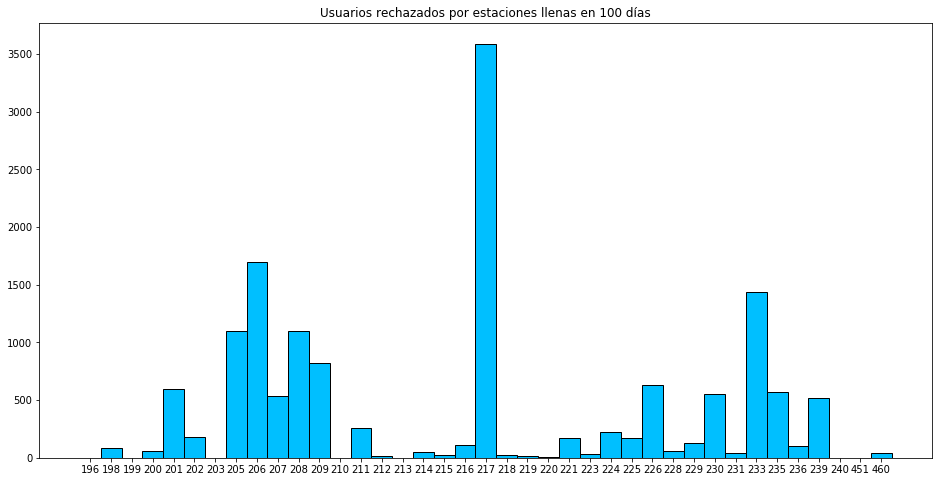

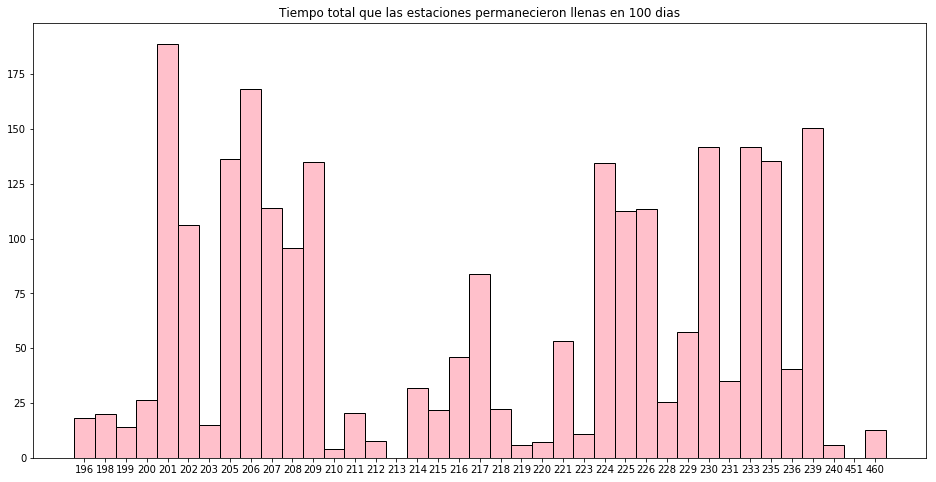

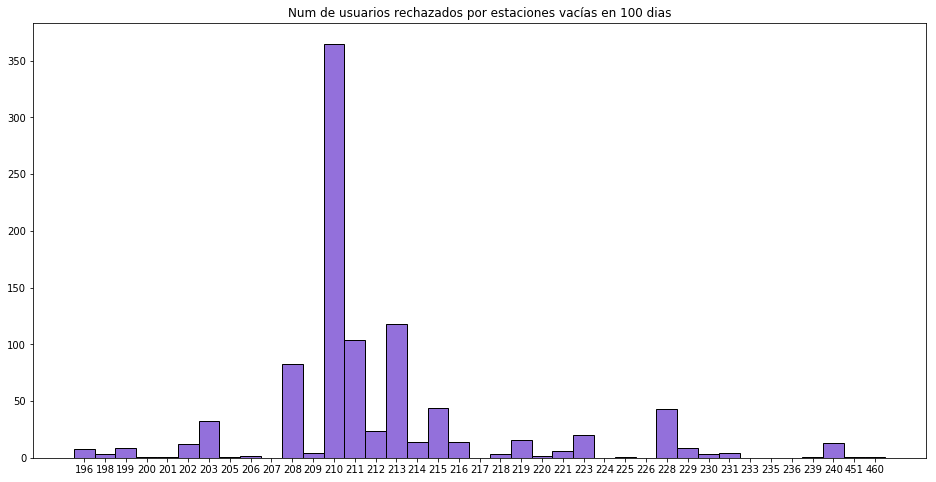

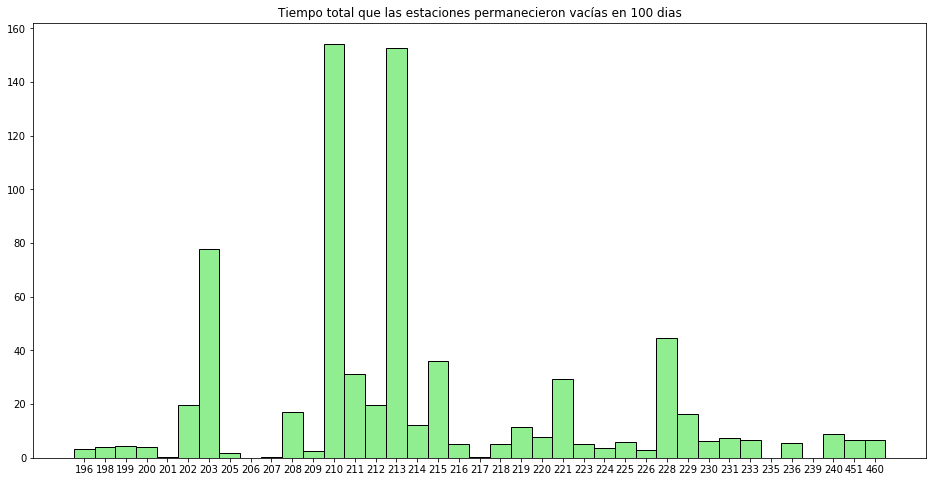

In [27]:
estado = np.zeros(39)
estado1 = np.zeros(39) 
estado2 = np.zeros(39) 
estado3 = np.zeros(39) 
auxi= np.zeros(39)
for i in range(0,k):
    n = np.random.randint(1,15,39)
    n = np.append(n, 6800 - sum(n))
    
    
    #auxi = x[4]
    estado = estado + Simulacion(n, capacidad, tasa, suma, A, forma, escala, theta)[1]
    
    estado1 = estado1 + Simulacion(n, capacidad, tasa, suma, A, forma, escala, theta)[3]
    
    estado2 = estado2 + Simulacion(n, capacidad, tasa, suma, A, forma, escala, theta)[2]
    
    estado3 = estado3 + Simulacion(n, capacidad, tasa, suma, A, forma, escala, theta)[4]

f, ax = plt.subplots(figsize=(16,8))
plt.bar(nombre_estaciones, estado, align = 'center', width = 1,color= 'deepskyblue', edgecolor= 'black')
plt.title('Usuarios rechazados por estaciones llenas en '+ str(k) + ' días')
plt.show()

f, ax = plt.subplots(figsize=(16,8))
plt.bar(nombre_estaciones, estado1, align = 'center', width = 1,color= 'pink', edgecolor= 'black')
plt.title('Tiempo total que las estaciones permanecieron llenas en ' +str(k)+ ' dias')
plt.show()


f, ax = plt.subplots(figsize=(16,8))
plt.bar(nombre_estaciones, estado2, align = 'center', width = 1,color= 'mediumpurple', edgecolor= 'black')
plt.title('Num de usuarios rechazados por estaciones vacías en ' +str(k)+ ' dias')
plt.show()


f, ax = plt.subplots(figsize=(16,8))
plt.bar(nombre_estaciones, estado3, align = 'center', width = 1,color= 'lightgreen', edgecolor= 'black')
plt.title('Tiempo total que las estaciones permanecieron vacías en ' +str(k)+ ' dias')
plt.show()
